# NLP for topic extraction and sentiment analysis for product reviews


In this demo we are using a dataset from amazon reviews on an electronic device.

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Methodology/marketing/amazon_reviews.csv'


df = pd.read_csv(file_path).dropna()

# List out our columns
df.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4913 entries, 1 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4913 non-null   int64  
 1   reviewerName          4913 non-null   object 
 2   overall               4913 non-null   float64
 3   reviewText            4913 non-null   object 
 4   reviewTime            4913 non-null   object 
 5   day_diff              4913 non-null   int64  
 6   helpful_yes           4913 non-null   int64  
 7   helpful_no            4913 non-null   int64  
 8   total_vote            4913 non-null   int64  
 9   score_pos_neg_diff    4913 non-null   int64  
 10  score_average_rating  4913 non-null   float64
 11  wilson_lower_bound    4913 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 499.0+ KB


In [ ]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
list(df)

['Unnamed: 0',
 'reviewerName',
 'overall',
 'reviewText',
 'reviewTime',
 'day_diff',
 'helpful_yes',
 'helpful_no',
 'total_vote',
 'score_pos_neg_diff',
 'score_average_rating',
 'wilson_lower_bound']

In [ ]:
df.rename(columns = {'Unnamed: 0':'Id'}, inplace = True)

## Quick EDA - Explanatory Data Analysis

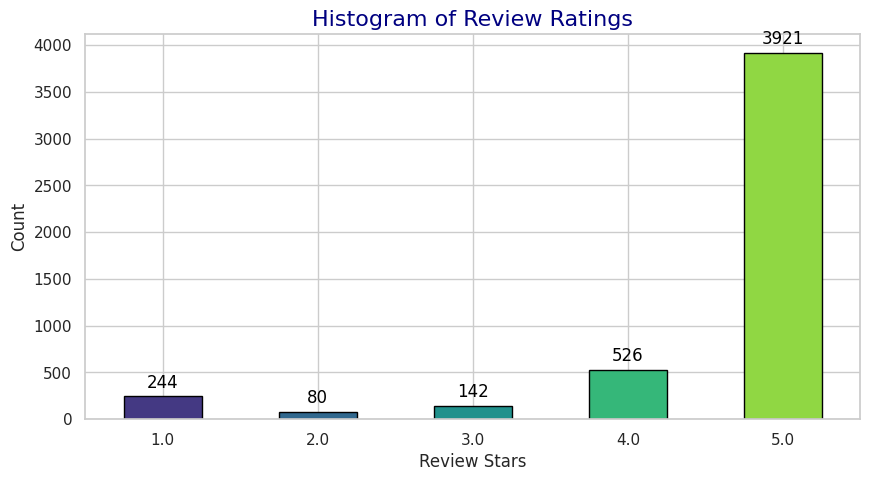

In [ ]:
# Setting the style
sns.set(style="whitegrid")

# Creating a bar plot
ax = df['overall'].value_counts().sort_index().plot(
    kind='bar',
    color=sns.color_palette('viridis', len(df['overall'].unique())),  # Use a color palette
    edgecolor='black',  # Add black borders for better visibility
    figsize=(10, 5)
)

# Set title and labels
ax.set_title('Histogram of Review Ratings', fontsize=16, color='navy')
ax.set_xlabel('Review Stars', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# x-axis ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')

plt.show()


In this graph we are analyzing the distribution on the overall rating. As we can see, the analyzed product has many more comments for the 5 star rating. Let's now see how customer rating changed through time.

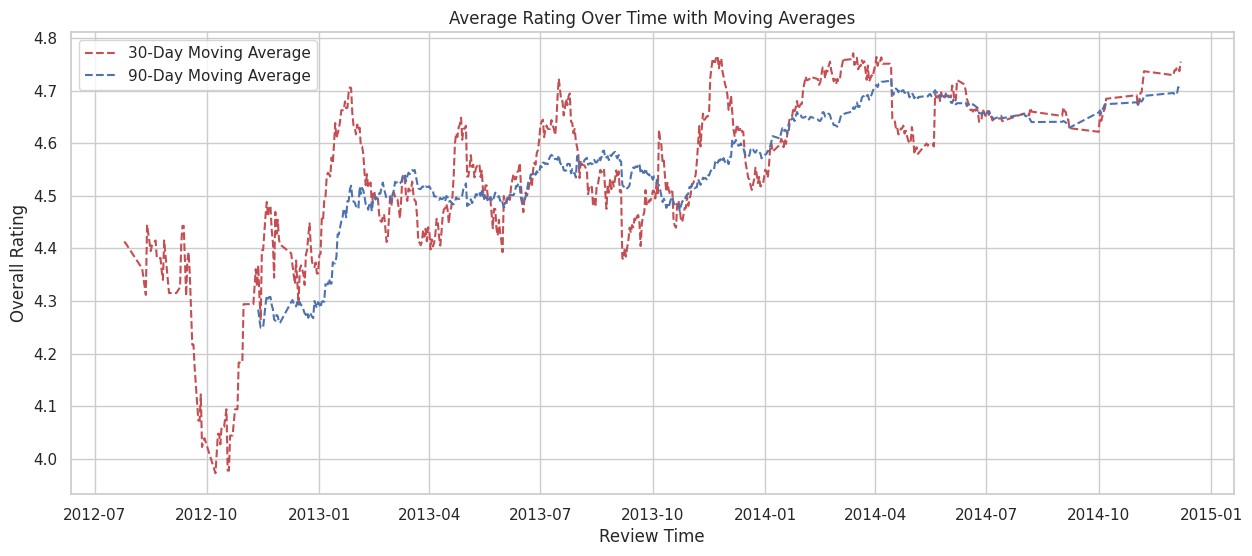

In [ ]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Group by 'reviewTime' and calculate the average overall rating for each day
average_ratings = df.groupby('reviewTime')['overall'].mean().reset_index()

# Calculate the 30-day moving average
average_ratings['moving_average'] = average_ratings['overall'].rolling(window=30).mean()

# Calculate the 90-day moving average
average_ratings['moving_average_90'] = average_ratings['overall'].rolling(window=90).mean()

# Plot the graph
plt.figure(figsize=(15, 6))
#plt.plot(average_ratings['reviewTime'], average_ratings['overall'], marker='o', linestyle='-', color='b', label='Daily Average')
plt.plot(average_ratings['reviewTime'], average_ratings['moving_average'], linestyle='--', color='r', label='30-Day Moving Average')
plt.plot(average_ratings['reviewTime'], average_ratings['moving_average_90'], linestyle='--', color='b', label='90-Day Moving Average')
plt.title('Average Rating Over Time with Moving Averages')
plt.xlabel('Review Time')
plt.ylabel('Overall Rating')
plt.legend()
plt.grid(True)
plt.show()

We use the moving averages to illustrate in a clear way the trend in average customer ratings over time, as the data is very volatile from day to day.

## NLP on one observation to test the model

In [ ]:
#Example for one observation
example = df['reviewText'][4900]
print(example)

NameError: name 'df' is not defined

In [ ]:
import nltk

# Download the punkt resource
nltk.download('punkt')

# Download the averaged_perceptron_tagger resource
nltk.download('averaged_perceptron_tagger')

# Download the maxent_ne_chunker resource
nltk.download('maxent_ne_chunker')

# Download the words resource
nltk.download('words')

Tokenization in Natural Language Processing (NLP) refers to the process of breaking down a text into smaller, meaningful units called tokens. These tokens could be words, phrases, sentences, or even individual characters, depending on the level of granularity required for analysis. In our case, the granularity level is mostly at the level of words.

In [ ]:
#tokenize the review
tokens = nltk.word_tokenize(example)
tokens[:10]

In [ ]:
# Classifying by POS - part of speach. The built-in function is able to recognize the grammatical category of each word
# We took as an example the first ten words of this review. The result is a list of tuples.
#For example,
#RB - Adverb
#PRP - Proper pronoun
#VDB - Past Tense Verb
#JJ - Adjective
#NNP - Proper Noun
#NN - Noun
tagged = nltk.pos_tag(tokens)
tagged[:10]

In [ ]:
#Put tagged review into entities
entities = nltk.chunk.ne_chunk(tagged)

# make the tree readable
# entities.pprint()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


# Roberta Model

The Roberta model is going to be applied on the whole dataset giving results on the percentage of positive, neutral and negative elements present in each of the comments.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
#Running roberta
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.016683247, 'roberta_neu': 0.15240963, 'roberta_pos': 0.8309071}


In [ ]:
#Running the model on the entire dataset
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}  # Dictionary to store results

# Loop through each row in the DataFrame
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Extract review text and ID from the current row
        text = row['reviewText']
        myid = row['Id']

        # Perform sentiment analysis using Roberta-based method
        roberta_result = polarity_scores_roberta(text)

        # Store the result in the dictionary with the ID as the key
        res[myid] = roberta_result

    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4913 [00:00<?, ?it/s]

Broke for id 76
Broke for id 123


KeyboardInterrupt: 

In [ ]:
#Visualize the resulting dictionary
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0.007265,0.095529,0.897206,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,0.423757,0.448311,0.127933,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,0.002447,0.019229,0.978324,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,0.003552,0.067459,0.928989,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,0.074017,0.398571,0.527412,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


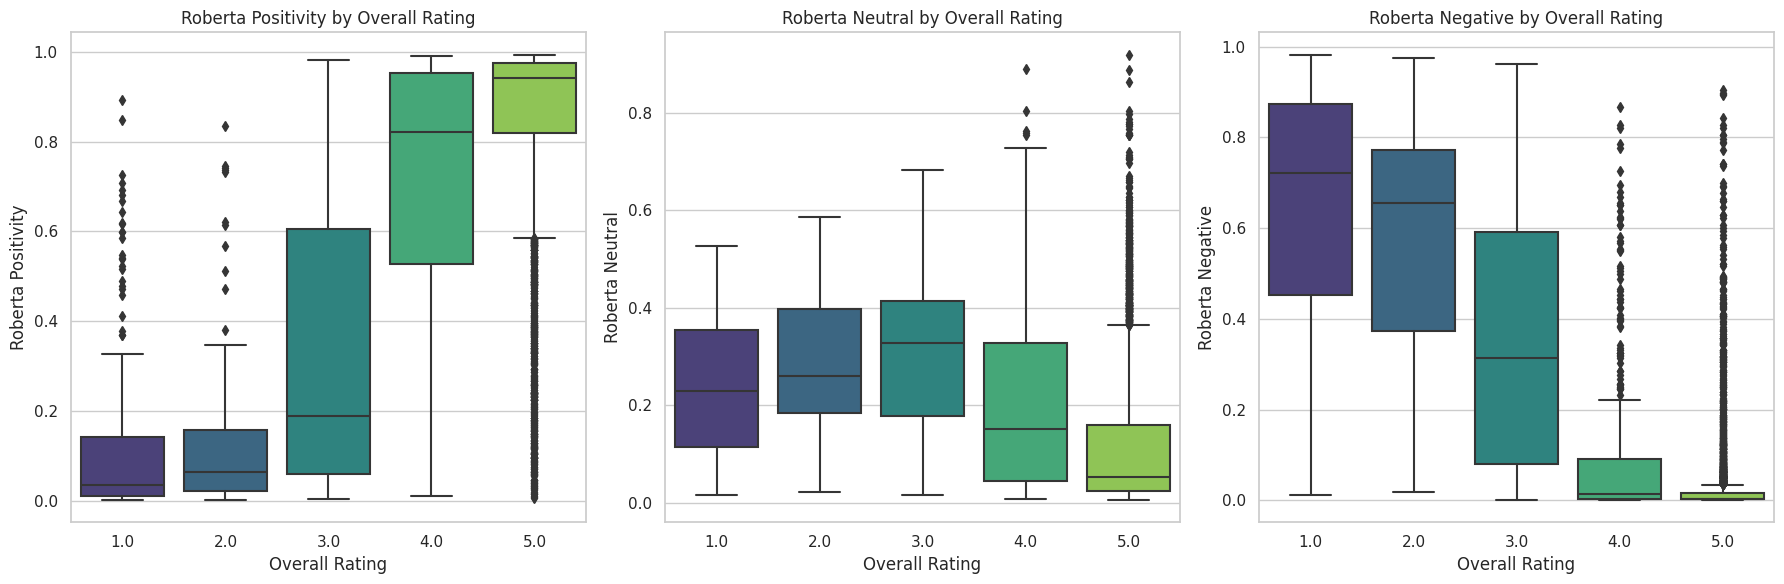

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for roberta_pos
sns.boxplot(ax=axes[0], x='overall', y='roberta_pos', data=results_df, palette='viridis')
axes[0].set_title('Roberta Positivity by Overall Rating')
axes[0].set_xlabel('Overall Rating')
axes[0].set_ylabel('Roberta Positivity')

# Box plot for roberta_neu
sns.boxplot(ax=axes[1], x='overall', y='roberta_neu', data=results_df, palette='viridis')
axes[1].set_title('Roberta Neutral by Overall Rating')
axes[1].set_xlabel('Overall Rating')
axes[1].set_ylabel('Roberta Neutral')

# Box plot for roberta_neg
sns.boxplot(ax=axes[2], x='overall', y='roberta_neg', data=results_df, palette='viridis')
axes[2].set_title('Roberta Negative by Overall Rating')
axes[2].set_xlabel('Overall Rating')
axes[2].set_ylabel('Roberta Negative')

plt.tight_layout()

plt.show()

Let's understand some interesting observations as the amount of outliers for the 5 star ratings displaying a rather negative sentiment according to the language model. To do so, let's look at some extreme cases.

In [ ]:
# Get the least positive review with an overall rating of 5.0
least_positive_review = results_df.query('overall == 5.0') \
    .sort_values('roberta_pos', ascending=True).iloc[0]

# Extract review text and Roberta_pos value
review_text = least_positive_review['reviewText']
roberta_pos_value = least_positive_review['roberta_pos']

# Extract review text and Roberta_pos value
roberta_neg_value = least_positive_review['roberta_neg']

# Print or use the values as needed
print("Review Text:")
print(review_text)

print("\nRoberta_pos Value:")
print(roberta_pos_value)

print("\nRoberta_neg Value:")
print(roberta_neg_value)

Review Text:
My only problem is that I have not been able to use its full potential.

Roberta_pos Value:
0.0072883195

Roberta_neg Value:
0.89505714


This review is categorized by Roberta as the most negative comment with a five star rating. As we can see, the nuance of the comment is not grasped by the model perfectly.

<ipython-input-25-498fef8d4f72>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_ratings = results_df.groupby('reviewTime')['overall','roberta_pos'].mean().reset_index()


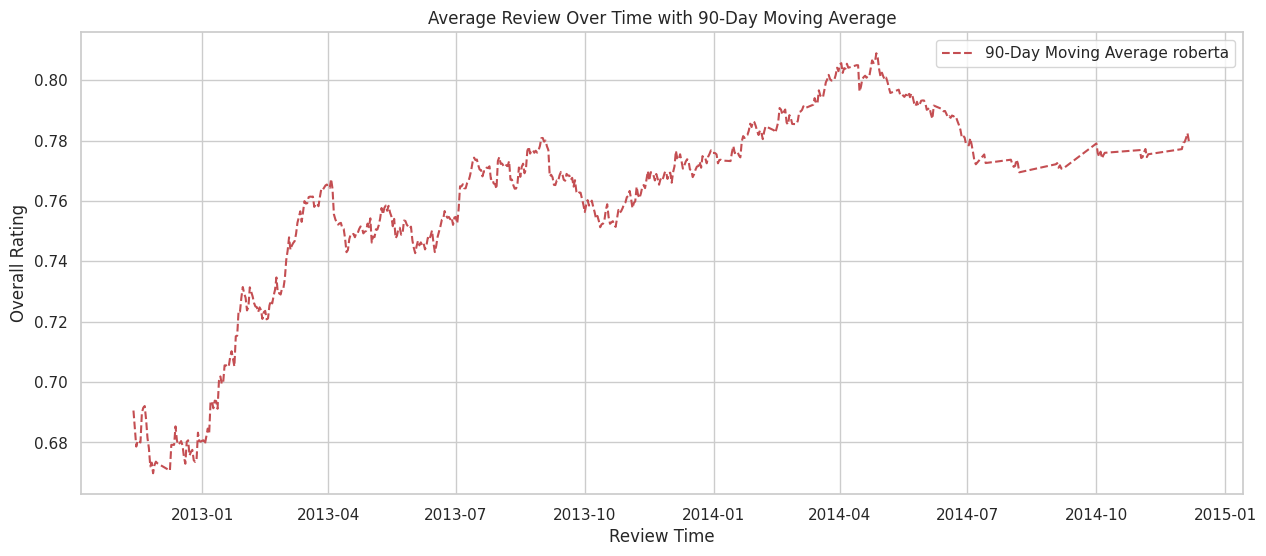

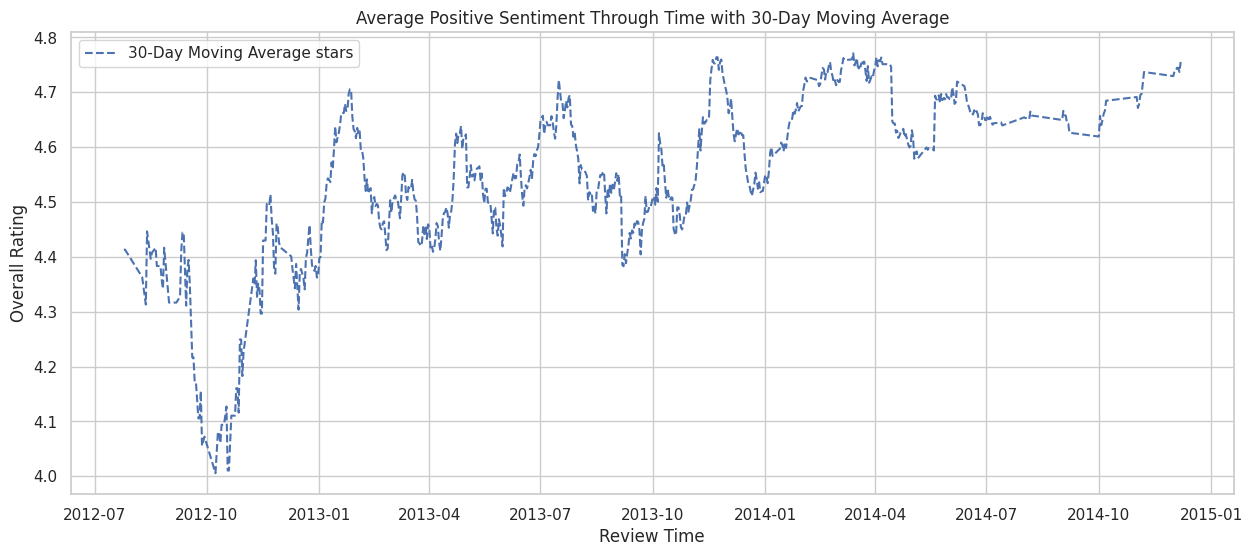

In [ ]:
#df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Group by 'reviewTime' and calculate the average overall rating for each day
average_ratings = results_df.groupby('reviewTime')['overall','roberta_pos'].mean().reset_index()


# Calculate the 90-day moving average
average_ratings['moving_average_90_stars'] = average_ratings['overall'].rolling(window=90).mean()

# Calculate the 90-day moving average
average_ratings['moving_average_90_roberta'] = average_ratings['roberta_pos'].rolling(window=90).mean()

# Plot the graph
plt.figure(figsize=(15, 6))
#plt.plot(average_ratings['reviewTime'], average_ratings['moving_average_90_stars'], linestyle='--', color='b', label='90-Day Moving Average stars')
plt.plot(average_ratings['reviewTime'], average_ratings['moving_average_90_roberta'], linestyle='--', color='r', label='90-Day Moving Average roberta')
plt.title('Average Review Over Time with 90-Day Moving Average')
plt.xlabel('Review Time')
plt.ylabel('Overall Rating')
plt.legend()
plt.grid(True)
plt.show()


# Calculate the 30-day moving average
average_ratings['moving_average_30_stars'] = average_ratings['overall'].rolling(window=30).mean()
# Plot the graph
plt.figure(figsize=(15, 6))
plt.plot(average_ratings['reviewTime'], average_ratings['moving_average_30_stars'], linestyle='--', color='b', label='30-Day Moving Average stars')
#plt.plot(average_ratings['reviewTime'], average_ratings['moving_average_30_roberta'], linestyle='--', color='r', label='30-Day Moving Average roberta')
plt.title('Average Positive Sentiment Through Time with 30-Day Moving Average')
plt.xlabel('Review Time')
plt.ylabel('Overall Rating')
plt.legend()
plt.grid(True)
plt.show()

As it is possible to see the general increase in stars review is also captured by Roberta by the increase through time of the average positive rating, proving the reliablity of Roberta.

## Topic visualization for categories

In [ ]:
pip install WordCloud

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

These are the most used adjectives and nouns for star rating 1 (figure 2), and 5 (figure 1). These cases are selected with the purpose of highlighting strenghts and weakenesses of the products so that the company can focus on the most important issues perceived by the customers.

## BERT

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 9.4 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039296 sha256=60d574811d048eec0e797077d3fbc42837de4d7efcf8f16c5d5475329ce865ce
  Stored in di

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from umap import UMAP


In [ ]:
umap_model = UMAP(random_state=42)

topic_model = BERTopic(umap_model=umap_model)

In [ ]:
from bertopic import BERTopic
from umap import UMAP
representation_model = KeyBERTInspired()
umap = UMAP(n_neighbors=15,
            n_components=2,
            min_dist=0.0,
            metric='euclidean',
            low_memory=False,
            random_state=1337)

topic_model = BERTopic("english", verbose=True, nr_topics=10, representation_model=representation_model,umap_model=umap)

In [ ]:
df_list = df['reviewText'].tolist()


In [ ]:
topics, probs = topic_model.fit_transform(df_list)

2024-01-07 13:09:11,104 - BERTopic - Embedding - Transforming documents to embeddings.


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/154 [00:00<?, ?it/s]

2024-01-07 13:09:44,275 - BERTopic - Embedding - Completed ✓
2024-01-07 13:09:44,276 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-07 13:10:20,880 - BERTopic - Dimensionality - Completed ✓
2024-01-07 13:10:20,882 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-07 13:10:21,014 - BERTopic - Cluster - Completed ✓
2024-01-07 13:10:21,015 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-07 13:10:23,251 - BERTopic - Representation - Completed ✓
2024-01-07 13:10:23,252 - BERTopic - Topic reduction - Reducing number of topics
2024-01-07 13:10:24,039 - BERTopic - Topic reduction - Reduced number of topics from 73 to 10


In [ ]:
freq = topic_model.get_topic_info()

In [ ]:
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1999,-1_sandisk_microsd_card_sd,"[sandisk, microsd, card, sd, storage, cards, m...","[My ipod finally bit the dust, so I bought thi..."
1,0,1577,0_sandisk_microsd_card_cards,"[sandisk, microsd, card, cards, samsung, sd, s...",[I guess I should be happy it failed after onl...
2,1,341,1_gopro_sandisk_hero3_card,"[gopro, sandisk, hero3, card, camera, sd, card...","[My Droid Razr runs a little slow, is it becau..."
3,2,312,2_storage_samsung_32gb_memory,"[storage, samsung, 32gb, memory, tablet, galax...",[I can take plenty of pictures and put all my ...
4,3,182,3_samsung_smartphone_galaxy_s3,"[samsung, smartphone, galaxy, s3, s4, android,...",[Bought this for use in my Samsung Galaxy S3 p...
5,4,153,4_surface_tablet_device_adapter,"[surface, tablet, device, adapter, microsoft, ...",[I bought this for my Microsoft Surface rt and...
6,5,137,5_does_complaints_working_advertised,"[does, complaints, working, advertised, worked...","[Works, had to give a review of this since it ..."
7,6,111,6_usb_minidrive_speeds_samsung,"[usb, minidrive, speeds, samsung, storage, spe...",[I was really excited when this came out I hav...
8,7,55,7_cheap_price_cost_purchase,"[cheap, price, cost, purchase, sale, buying, s...","[I got it at a good price, and it is nice to h..."
9,8,46,8_packaging_packaged_card_shipping,"[packaging, packaged, card, shipping, sd, spee...",[Received my card in a decent amount of time a...


In [ ]:
topic_model.visualize_topics()

In [ ]:
timestamps = df['reviewTime']

In [ ]:
timestamps = df['reviewTime'].tolist()

merged_list = [{'text': text, 'timestamp': timestamp} for text, timestamp in zip(df_list, timestamps)]


In [ ]:
timestamps_series = pd.Series(timestamps)

topics_over_time = topic_model.topics_over_time(df_list, timestamps_series, nr_bins=20)

20it [00:07,  2.53it/s]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
df

,body,rating
0,Awesome phone,5
1,Bought mine on project fi. Hands down the wors...,1
2,Ordered 2 and one is perfect condition just li...,1
3,I really like this phone. Got it to replace th...,4
4,Its definitely the US version but it's not unl...,4
...,...,...
14995,"Phone itself is great, the Verizon packaging w...",4
14996,I'm very pleased with this phone thus far! I'v...,4
14997,I buy phones online all the time and this phon...,1
14998,I've had a G6 since it was first released and ...,4


In [ ]:
train = df[['body', 'rating']]

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.reviewText
        self.targets = self.data.overall
        self.max_len = max_len
        self.topics = None
        self.indices = dataframe.index.tolist()  # Store the original indices

    def set_topics(self, topics):
        self.topics = topics

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'index': self.indices[index]  # Include the original index
        }


In [ ]:

train_data=df
test_data=dftest



print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (15000, 2)
TRAIN Dataset: (15000, 2)
TEST Dataset: (4913, 2)


AttributeError: 'DataFrame' object has no attribute 'body'

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
print(test_data.columns)


Index(['Id', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff',
       'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound'],
      dtype='object')


In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

# Changing optimizer to AdamW
optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE)

# Defining Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Using Focal Loss
loss_function = FocalLoss()

# Rest of the code remains unchanged

In [ ]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Loss per 5000 steps: 1.0069563388824463
Training Accuracy per 5000 steps: 0.0


492it [02:53,  2.83it/s]

The Total Accuracy for Epoch 0: 81.04325699745547
Training Loss Epoch: 0.31843752798442615
Training Accuracy Epoch: 81.04325699745547


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    all_indices = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            indices = data['index']  # Get the original indices

            outputs = model(ids, mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_indices.extend(indices.tolist())

    return all_preds, all_targets, all_indices

# After training, get the validation predictions, targets, and indices
val_preds, val_targets, val_indices = evaluate(model, testing_loader)

# Map the indices back to the original dataset
original_val_indices = testing_set.indices
original_val_indices = [original_val_indices[i] for i in val_indices]

# Now, original_val_indices contains the original indices of the validation set
print("Original Validation Indices:", original_val_indices)


246it [00:14, 16.70it/s]

Original Validation Indices: [714, 82, 366, 653, 16, 380, 423, 982, 929, 716, 67, 327, 833, 469, 87, 686, 515, 794, 443, 766, 809, 670, 54, 43, 422, 148, 821, 967, 715, 152, 969, 238, 688, 499, 549, 592, 848, 501, 81, 190, 909, 862, 31, 0, 104, 482, 953, 192, 467, 445, 748, 356, 212, 814, 470, 44, 510, 109, 739, 441, 679, 202, 27, 754, 272, 582, 578, 146, 545, 586, 763, 907, 420, 373, 566, 318, 980, 525, 932, 542, 72, 200, 488, 611, 141, 677, 724, 170, 263, 938, 743, 376, 23, 34, 710, 129, 665, 189, 253, 215, 704, 606, 130, 275, 583, 243, 520, 206, 876, 58, 843, 345, 157, 726, 541, 88, 603, 353, 564, 954, 601, 437, 334, 966, 481, 147, 224, 119, 694, 699, 466, 591, 297, 674, 236, 976, 742, 281, 9, 254, 401, 340, 871, 956, 359, 891, 965, 463, 398, 604, 324, 390, 797, 350, 830, 543, 465, 552, 801, 580, 1, 855, 126, 176, 458, 802, 588, 718, 841, 764, 375, 805, 919, 391, 889, 108, 351, 632, 182, 284, 116, 568, 331, 165, 156, 438, 605, 785, 464, 343, 921, 941, 681, 307, 70, 961, 279, 283, 38

In [ ]:
new = df
val_preds

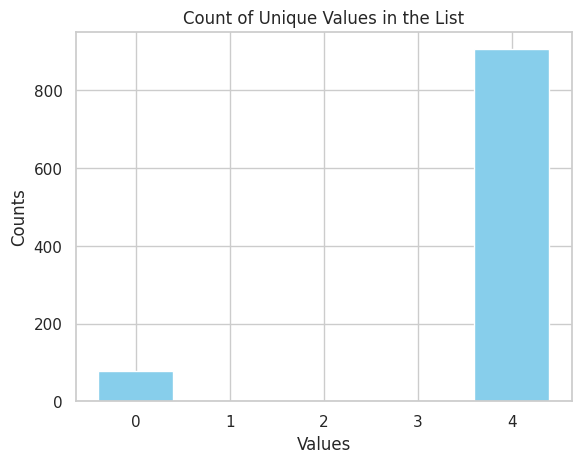

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample list
data_list = val_preds

# Count occurrences using Counter
counter = Counter(data_list)

# Extract values and counts
values = list(counter.keys())
counts = list(counter.values())

# Create a bar plot
plt.bar(values, counts, color='skyblue')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Count of Unique Values in the List')
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/20191226-reviews.csv'

df = pd.read_csv(file_path).dropna()
num_observations = 15000
df = df.sample(n=num_observations, replace=True)
df.reset_index(drop=True, inplace=True)
df

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0766TPHSH,Kristhian A De Oliveira,5,"March 23, 2018",True,Five Stars,Awesome phone,1.0
1,B0766NJPBN,RS,1,"November 3, 2017",False,Don't buy,Bought mine on project fi. Hands down the wors...,42.0
2,B07CGMQDXW,Elizabeth Clasey,1,"March 7, 2018",True,Ordered 2 and one is perfect condition just li...,Ordered 2 and one is perfect condition just li...,162.0
3,B002WTC1NG,AZreader,4,"July 13, 2011",False,Good basic phone,I really like this phone. Got it to replace th...,3.0
4,B07N4M412B,Jezabel Heredia,4,"September 4, 2019",True,AT&T carrier,Its definitely the US version but it's not unl...,1.0
...,...,...,...,...,...,...,...,...
14995,B006OU39QW,Thomas W Gogerty,4,"April 16, 2017",True,"Phone itself is great, the Verizon packaging w...","Phone itself is great, the Verizon packaging w...",1.0
14996,B01NC157KR,Eri,4,"May 1, 2018",True,Happy with my purchase :),I'm very pleased with this phone thus far! I'v...,1.0
14997,B01FIW1B9S,Idris,1,"April 25, 2018",True,Bad Seller? or Bad Luck?,I buy phones online all the time and this phon...,15.0
14998,B07CHW5KMY,bevhoward,4,"December 11, 2019",True,Not all MotoG6's are the Same,I've had a G6 since it was first released and ...,1.0


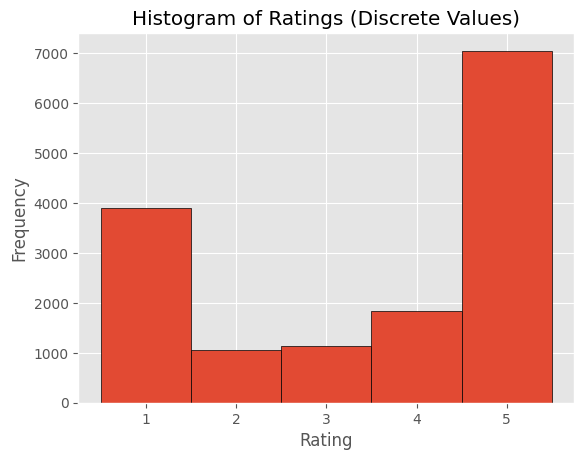

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing a 'rating' column

# Plotting histogram with discrete values (1, 2, 3, 4, 5)
plt.hist(df['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')  # Define bins for discrete values
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings (Discrete Values)')
plt.xticks([1, 2, 3, 4, 5])  # Set x-axis ticks for discrete values (1, 2, 3, 4, 5)
plt.show()



In [ ]:
dftest

,Id,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
5,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.0,I bought this Sandisk 16GB Class 10 to use wit...,2013-07-23,503,0,0,0,0,0.0,0.0
4911,4911,Zo,5.0,Used this for extending the capabilities of my...,2013-08-22,473,0,0,0,0,0.0,0.0
4912,4912,Z S Liske,5.0,Great card that is very fast and reliable. It ...,2014-03-31,252,0,0,0,0,0.0,0.0
4913,4913,Z Taylor,5.0,Good amount of space for the stuff I want to d...,2013-09-16,448,0,0,0,0,0.0,0.0


In [ ]:
columns_to_keep = ['reviewText', 'overall']
dftest = dftest[columns_to_keep]
dftest.reset_index(drop=True, inplace=True)

In [ ]:
columns_to_keep = ['body', 'rating']
df = df[columns_to_keep]
df

,body,rating
0,Awesome phone,5
1,Bought mine on project fi. Hands down the wors...,1
2,Ordered 2 and one is perfect condition just li...,1
3,I really like this phone. Got it to replace th...,4
4,Its definitely the US version but it's not unl...,4
...,...,...
14995,"Phone itself is great, the Verizon packaging w...",4
14996,I'm very pleased with this phone thus far! I'v...,4
14997,I buy phones online all the time and this phon...,1
14998,I've had a G6 since it was first released and ...,4


In [ ]:
train_data=df
test_data=dftest
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (15000, 2)
TRAIN Dataset: (15000, 2)
TEST Dataset: (4913, 2)


NameError: name 'SentimentData' is not defined

In [ ]:
dfcolumns_to_keeptrain = ['reviewText', 'overall']
df = df[dfcolumns_to_keeptrain]

In [ ]:
df

,reviewText,overall
1,"Purchased this for my device, it worked as adv...",4.0
2,it works as expected. I should have sprung for...,3.0
3,This think has worked out great.Had a diff. br...,4.0
4,"Bought it with Retail Packaging, arrived legit...",4.0
5,It's mini storage. It doesn't do anything els...,4.0
...,...,...
4910,I bought this Sandisk 16GB Class 10 to use wit...,0.0
4911,Used this for extending the capabilities of my...,4.0
4912,Great card that is very fast and reliable. It ...,4.0
4913,Good amount of space for the stuff I want to d...,4.0


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

# Changing optimizer to AdamW
optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE)

# Defining Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Using Focal Loss
loss_function = FocalLoss()

# Rest of the code remains unchanged

In [ ]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

1it [00:00,  4.63it/s]

Training Loss per 5000 steps: 0.8613303899765015
Training Accuracy per 5000 steps: 62.5


615it [03:42,  2.76it/s]

The Total Accuracy for Epoch 0: 81.94585792794626
Training Loss Epoch: 0.30593368980155244
Training Accuracy Epoch: 81.94585792794626


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    all_indices = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            indices = data['index']  # Get the original indices

            outputs = model(ids, mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_indices.extend(indices.tolist())

    return all_preds, all_targets, all_indices

# After training, get the validation predictions, targets, and indices
val_preds, val_targets, val_indices = evaluate(model, testing_loader)

# Map the indices back to the original dataset
original_val_indices = testing_set.indices
original_val_indices = [original_val_indices[i] for i in val_indices]

# Now, original_val_indices contains the original indices of the validation set
print("Original Validation Indices:", original_val_indices)


6802it [06:55, 16.38it/s]

Original Validation Indices: [18721, 7787, 2040, 14281, 24135, 20688, 16103, 6905, 16357, 1436, 12324, 13972, 3433, 5278, 5834, 23189, 23272, 17604, 8532, 25899, 2539, 2997, 6264, 5773, 9498, 11188, 25056, 15592, 22539, 8703, 3320, 4477, 7911, 10409, 26756, 6429, 15771, 2525, 10868, 23165, 10256, 4095, 21228, 16513, 7123, 19541, 20639, 1314, 22367, 10321, 10361, 9546, 23459, 19976, 18383, 16022, 15866, 4734, 13210, 12322, 20700, 20446, 5512, 6666, 25737, 112, 23741, 26631, 12961, 19360, 25494, 11909, 18021, 20566, 1478, 21860, 23522, 18588, 18885, 16638, 7682, 16767, 12751, 21427, 3621, 21344, 16736, 23806, 1959, 7548, 651, 1358, 22754, 15244, 11026, 24627, 23448, 21803, 3384, 15261, 5080, 10343, 735, 8149, 27124, 22490, 11104, 7606, 16442, 23050, 6243, 16869, 308, 11399, 2434, 23223, 22062, 26571, 9612, 6807, 4184, 4663, 25000, 18392, 3270, 23921, 19258, 2459, 1549, 2938, 8824, 20055, 16610, 18816, 6062, 4470, 26661, 23968, 18489, 11241, 16700, 7023, 12944, 8129, 15735, 24463, 11356, 

In [ ]:
new = df
val_preds

[0,
 3,
 4,
 4,
 2,
 4,
 0,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 2,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 2,
 0,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 3,
 0,
 4,
 4,
 4,
 3,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 3,
 0,
 0,
 4,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 2,
 0,
 4,
 0,
 0,
 4,
 4,
 4,


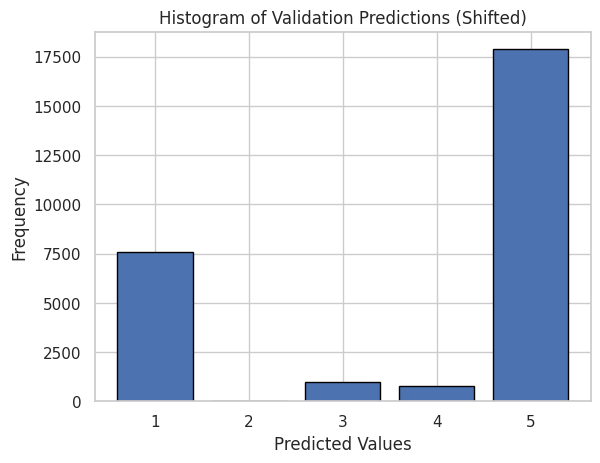

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming val_preds is a list or NumPy array containing the prediction values
val_preds_shifted = np.array(val_preds) + 1  # Adding 1 to each value
bins = np.arange(1, 7) - 0.5  # Creating bins for discrete values (1, 2, 3, 4, 5)

plt.hist(val_preds_shifted, bins=bins, rwidth=0.8, edgecolor='black')  # Adjust rwidth and edgecolor as needed
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Validation Predictions (Shifted)')
plt.xticks(np.arange(1, 6))  # Set x-axis ticks for discrete values (1, 2, 3, 4, 5)
plt.show()


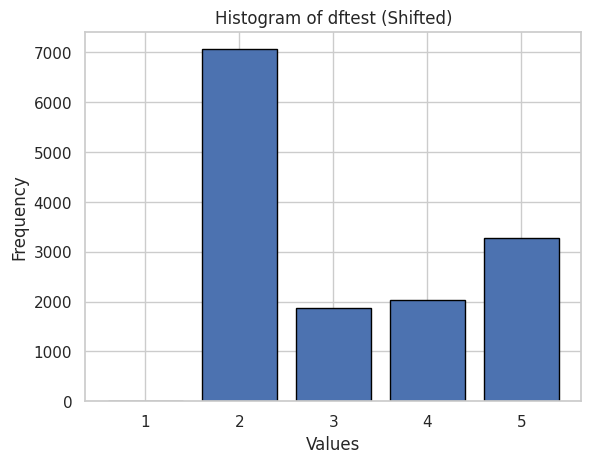

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dftest is a Pandas DataFrame column or a list/array of numerical values
# Replace this with your actual data

dftest_shifted = dftest["overall"] + 1  # Adding 1 to each value
bins = np.arange(1, 7) - 0.5  # Creating bins for discrete values (1, 2, 3, 4, 5)

plt.hist(dftest_shifted, bins=bins, rwidth=0.8, edgecolor='black')  # Adjust rwidth and edgecolor as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of dftest (Shifted)')
plt.xticks(np.arange(1, 6))  # Set x-axis ticks for discrete values (1, 2, 3, 4, 5)
plt.show()
